# Bigraph-Builder Demo

In [1]:
from builder import Builder, Process, ProcessTypes

## Initialize the builder

In [2]:
from biosimulator_processes import CORE

CobraProcess registered successfully.


TypeError: Too many parameters for typing.Dict; actual 3, expected 2

In [ ]:
b = Builder(core=CORE)

### register new types

In [3]:
b.register_type(
    'default 1', {
        '_inherit': 'float',
        '_default': 1.0})

## Register processes

### list built-in processes

In [4]:
b.list_processes()

['ram-emitter',
 'CobraProcess',
 'CopasiProcess',
 'console-emitter',
 'TelluriumProcess']

### register process with process class

In [5]:
from process_bigraph.experiments.minimal_gillespie import GillespieEvent
b.register_process('GillespieEvent', GillespieEvent)

### register process by address
currently only supports local addresses, but the plan is to support remote addresses and different protocols

In [6]:
b.register_process(
    'GillespieInterval',
    address='process_bigraph.experiments.minimal_gillespie.GillespieInterval',  
)

### register with decorator

In [7]:
@b.register_process('toy')
class Toy(Process):
    config_schema = {
        'A': 'float',
        'B': 'float'}

    def __init__(self, config, core):
        super().__init__(config, core)

    def schema(self):
        return {
            'inputs': {
                'A': 'float',
                'B': 'float'},
            'outputs': {
                'C': 'float'}}

    def update(self, state, interval):
        update = {'C': state['A'] + state['B']}
        return update


### list registered processes

In [5]:
b.list_processes()

['ram-emitter',
 'CobraProcess',
 'CopasiProcess',
 'console-emitter',
 'TelluriumProcess']

## Add processes to the bigraph

### add event_process

In [9]:
from biosimulator_processes.process_types import  MODEL_TYPE

MODEL_TYPE

{'model_id': 'string',
 'model_source': 'string',
 'model_language': {'_type': 'string', '_default': 'sbml'},
 'model_name': {'_type': 'string', '_default': 'composite_process_model'},
 'model_changes': {'species_changes': 'tree[string]',
  'global_parameter_changes': 'tree[string]',
  'reaction_changes': 'tree[string]'},
 'model_units': 'tree[string]'}

In [41]:
species_changes = ModelChange(config={
    'A': {
        'initial_expression': 'A -> B'
    }
})

global_params_changes = ModelChange(config={
    'Bol': {
        'unit': 'ml'
    }
})

model_changes = ModelChanges(species_changes=species_changes, global_parameter_changes=global_params_changes)


model = SedModel(
    model_id='BIO232423',
    model_source='uri:2424',
    model_language='sbml',
    model_name='Glyc',
    model_changes=model_changes
)


In [42]:
model.model_dump()

{'model_id': 'BIO232423',
 'model_source': 'uri:2424',
 'model_language': 'sbml',
 'model_name': 'Glyc',
 'model_changes': {'species_changes': {'config': {'A': {'initial_expression': 'A -> B'}}},
  'global_parameter_changes': {'config': {'Bol': {'unit': 'ml'}}},
  'reaction_changes': None}}

In [6]:
copasi_config = 
b['copasi_A'].add_process(
    name='CopasiProcess',
    kdeg=1.0,  # kwargs fill parameters in the config
)

Exception: config key kdeg not in config_schema for CopasiProcess

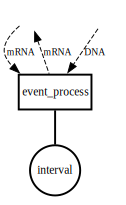

In [10]:
# visualize shows the process with its disconnected ports
b.visualize()

### print ports

In [11]:
b['event_process'].interface(True)

{ '_inputs': { 'DNA': {'A gene': 'float', 'B gene': 'float'},
               'mRNA': 'map[float]'},
  '_outputs': {'mRNA': 'map[float]'}}


### connect ports using connect_all
`Builder.connect_all` connects ports to stores of the same name.

In [12]:
b.connect_all(append_to_store_name='_store')
b

Builder({ 'event_process': { '_type': 'process',
                     'address': 'local:GillespieEvent',
                     'config': {'kdeg': 1.0, 'ktsc': 5.0},
                     'inputs': {'DNA': ['DNA_store'], 'mRNA': ['mRNA_store']},
                     'instance': <process_bigraph.experiments.minimal_gillespie.GillespieEvent object at 0x106c12dc0>,
                     'interval': 1.0,
                     'outputs': {'mRNA': ['mRNA_store']}}})

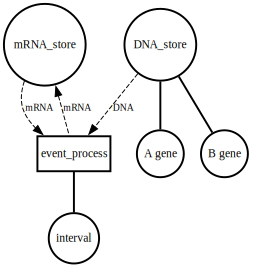

In [13]:
b.visualize()

### add interval process to the config

In [14]:
b['interval_process'].add_process(
    name='GillespieInterval',
)

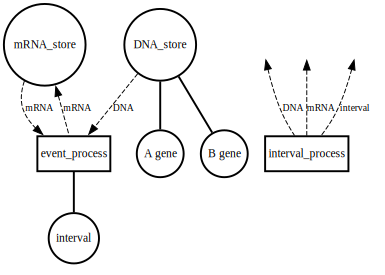

In [15]:
b.visualize()

### connect port to specific target

In [16]:
# to connect a port in a more targeted way, use connect and specify the port and its target path
b['interval_process'].connect(port='interval', target=['event_process', 'interval']) 

# the remaining ports can connect_all
b.connect_all() 

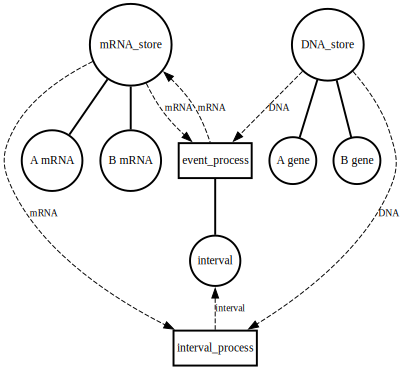

In [17]:
b.visualize()

### check current Builder config

In [18]:
b

Builder({ 'DNA_store': {'A gene': 0.0, 'B gene': 0.0},
  'event_process': { '_type': 'process',
                     'address': 'local:GillespieEvent',
                     'config': {'kdeg': 1.0, 'ktsc': 5.0},
                     'inputs': {'DNA': ['DNA_store'], 'mRNA': ['mRNA_store']},
                     'instance': <process_bigraph.experiments.minimal_gillespie.GillespieEvent object at 0x106c12dc0>,
                     'interval': 1.0,
                     'outputs': {'mRNA': ['mRNA_store']}},
  'interval_process': { '_type': 'step',
                        'address': 'local:GillespieInterval',
                        'config': {'kdeg': 0.1, 'ktsc': 5.0},
                        'inputs': { 'DNA': ['DNA_store'],
                                    'mRNA': ['mRNA_store']},
                        'instance': <process_bigraph.experiments.minimal_gillespie.GillespieInterval object at 0x106c118b0>,
                        'outputs': {'interval': ['event_process', 'interval']}},
  'm

## Update the initial state

In [19]:
initial_state = {
    'DNA_store': {
        'A gene': 2.0,
        'B gene': 1.0},
}
b.update(initial_state)

## Generate composite from builder config and simulate

In [20]:
composite = b.generate()
composite.run(10)

produced interval: {'interval': 1.21174311488629}
received interval: 1.21174311488629
produced interval: {'interval': 30.66671505248375}


In [21]:
composite

## Retrieve the composite document

In [22]:
doc = b.document()
doc

{'event_process': {'_type': 'process',
  'address': 'local:GillespieEvent',
  'config': {'kdeg': 1.0, 'ktsc': 5.0},
  'inputs': {'mRNA': ['mRNA_store'], 'DNA': ['DNA_store']},
  'outputs': {'mRNA': ['mRNA_store']},
  'interval': 1.0},
 'mRNA_store': {'A mRNA': '1.0', 'B mRNA': '1.0'},
 'DNA_store': {'A gene': '2.0', 'B gene': '1.0'},
 'interval_process': {'_type': 'step',
  'address': 'local:GillespieInterval',
  'config': {'ktsc': 5.0, 'kdeg': 0.1},
  'inputs': {'DNA': ['DNA_store'], 'mRNA': ['mRNA_store']},
  'outputs': {'interval': ['event_process', 'interval']}},
 'global_time': '0.0'}

### save the document to file

In [23]:
b.write(filename='toy_bigraph')

File 'toy_bigraph' successfully written in 'out' directory.


### load a composite from document
This document represents the full state of the composite, and so can reproduce the previous composite when loaded into a fresh Builder

In [26]:
b2 = Builder(core=core, file_path='out/toy_bigraph.json')
b2

Builder({ 'DNA_store': {'A gene': '2.0', 'B gene': '1.0'},
  'event_process': { '_type': 'process',
                     'address': 'local:GillespieEvent',
                     'config': {'kdeg': 1.0, 'ktsc': 5.0},
                     'inputs': {'DNA': ['DNA_store'], 'mRNA': ['mRNA_store']},
                     'instance': <process_bigraph.experiments.minimal_gillespie.GillespieEvent object at 0x105271250>,
                     'interval': 1.0,
                     'outputs': {'mRNA': ['mRNA_store']}},
  'global_time': '0.0',
  'interval_process': { '_type': 'step',
                        'address': 'local:GillespieInterval',
                        'config': {'kdeg': 0.1, 'ktsc': 5.0},
                        'inputs': { 'DNA': ['DNA_store'],
                                    'mRNA': ['mRNA_store']},
                        'instance': <process_bigraph.experiments.minimal_gillespie.GillespieInterval object at 0x105271130>,
                        'outputs': {'interval': ['event_p

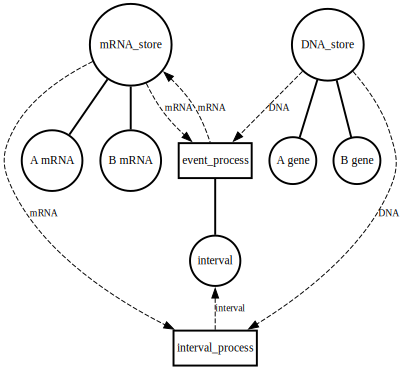

In [27]:
b2.visualize()